<a href="https://colab.research.google.com/github/martinamster/IA_Safety/blob/main/Sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sorting transformer

In this notebook I will try to develop a small transformer that can sort sequences of fixed length (one of Neel Nanda's (not so) open problems in mech interp). This project is my final project for the AI Safety Blue Dot course

##Imports and installs


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

##Configuration of the transformer


Here I define the transformer, which will have 2 heads and one layer. The numbers in the sequence to sort will be up to 50 and I will also define a begin token and end token, which may help the training of the transformer.

In [ ]:

class Config:
    def __init__(self):
        self.max_num = 50
        self.num_numbers = 5
        self.vocab_size = self.max_num + 2  # 0: begin, 1-50: numbers, 51: end
        self.seq_len = self.num_numbers + 2
        self.embed_dim = 256
        self.num_heads = 2
        self.num_layers = 1
        self.batch_size = 128
        self.num_epochs = 20
        self.learning_rate = 0.0005
        self.dropout = 0.1
        self.begin_token = 0
        self.end_token = self.max_num + 1  # 51

cfg = Config()

class SortingTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embed = nn.Embedding(config.vocab_size, config.embed_dim) # converts tokens into vector (embeddings)
        self.pos_embed = nn.Parameter(torch.randn(1, config.seq_len, config.embed_dim)) #this adds positional information. The transformers need to understand order to sort

        # Transformer
        self.transformer = nn.TransformerEncoder( #stacks multiple layers of TransformerEncoderLayer
            nn.TransformerEncoderLayer( #defines the layer of the transformer
                d_model=config.embed_dim,
                nhead=config.num_heads,
                dim_feedforward=config.embed_dim*4,
                dropout=config.dropout,
                batch_first=True
            ),
            num_layers=config.num_layers
        )

        self.fc = nn.Linear(config.embed_dim, config.vocab_size) #linear transformation which transforms embeddings into logits


    def forward(self, x):
        x = self.embed(x) + self.pos_embed #tokens to embeddings and then with position
        x = self.transformer(x)
        return self.fc(x) #applies final layer



##Generation of data


Here I will generate the data to train the model. It will have something like an input sequence and an output sequence (ordered). Remember that it will also have a begin token (0) and an end token (51)

In [ ]:
def generate_data(batch_size, config):
    numbers = torch.stack([
        torch.randperm(config.max_num)[:config.num_numbers] + 1
        for _ in range(batch_size)
    ]) #this generates a batch of sequences of random numbers. I use permutation because it's easier if it doesn't have repeated numbers

  #here I add begin and end token
    input_seq = torch.cat([
        torch.full((batch_size, 1), config.begin_token),
        numbers,
        torch.full((batch_size, 1), config.end_token)
    ], dim=1).long()


    targets = torch.cat([
        torch.full((batch_size, 1), config.begin_token),
        torch.sort(numbers, dim=1)[0],
        torch.full((batch_size, 1), config.end_token)
    ], dim=1).long()

    return input_seq, targets

generate_data(2, cfg)

(tensor([[ 0, 47, 12, 50, 19, 16, 51],
         [ 0, 47, 15, 31, 27,  9, 51]]),
 tensor([[ 0, 12, 16, 19, 47, 50, 51],
         [ 0,  9, 15, 27, 31, 47, 51]]))

##Training

First, I define a loss function based on cross entropy because I see this problem as a classification problem (which token in which position)

In [ ]:

def loss_fn(logits, targets, config):
    return F.cross_entropy(
        #to calculate loss for each token
        logits.view(-1, config.vocab_size),
        targets.view(-1)
        #label_smoothing=0.05 could use this but I feel better when the loss is lower
    )

Now I define a function to evaluate the model during the training


In [ ]:
def evaluate(model, config, num_samples=1000):
    model.eval()
    total_correct = 0

    for _ in range(num_samples):
        inputs, targets = generate_data(1, config)
        outputs = model(inputs).argmax(-1)

        if torch.all(outputs == targets):
            total_correct += 1

    return total_correct / num_samples

Now the training loop...

In [ ]:
losses = []
model = SortingTransformer(cfg)
#kind of standard optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

best_acc = 0
for epoch in range(cfg.num_epochs):
    model.train()
    total_loss = 0

    for _ in range(100): #100 batches per epoch
        inputs, targets = generate_data(cfg.batch_size, cfg)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets, cfg)
        loss.backward() #backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #limits gradients value
        optimizer.step()


        total_loss += loss.item()

    # Evaluation
    val_acc = evaluate(model, cfg)
    scheduler.step(loss) #adjust learning rate

    # saving the best model so far
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{cfg.num_epochs}")
    print(f"Loss: {total_loss/100:.4f} | Val Acc: {val_acc:.2%} | LR: {current_lr:.2e}")
    print("----------------------------------")
    losses.append(total_loss/100)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Some examples

test_input, test_target = generate_data(5, cfg)
predictions = model(test_input).argmax(-1)

for i in range(5):
    print(f"\nExample {i+1}:")
    print(f"Input:    {test_input[i].numpy()}")
    print(f"Target:   {test_target[i].numpy()}")
    print(f"Prediction: {predictions[i].cpu().numpy()}")


Epoch 1/20
Loss: 1.6585 | Val Acc: 8.80% | LR: 5.00e-04
----------------------------------
Epoch 2/20
Loss: 0.7460 | Val Acc: 21.80% | LR: 5.00e-04
----------------------------------
Epoch 3/20
Loss: 0.5183 | Val Acc: 48.00% | LR: 5.00e-04
----------------------------------
Epoch 4/20
Loss: 0.3974 | Val Acc: 67.10% | LR: 5.00e-04
----------------------------------
Epoch 5/20
Loss: 0.3326 | Val Acc: 78.30% | LR: 5.00e-04
----------------------------------
Epoch 6/20
Loss: 0.2974 | Val Acc: 81.80% | LR: 5.00e-04
----------------------------------
Epoch 7/20
Loss: 0.2690 | Val Acc: 87.90% | LR: 5.00e-04
----------------------------------
Epoch 8/20
Loss: 0.2491 | Val Acc: 91.50% | LR: 5.00e-04
----------------------------------
Epoch 9/20
Loss: 0.2348 | Val Acc: 88.70% | LR: 5.00e-04
----------------------------------
Epoch 10/20
Loss: 0.2221 | Val Acc: 92.40% | LR: 5.00e-04
----------------------------------
Epoch 11/20
Loss: 0.2115 | Val Acc: 92.40% | LR: 5.00e-04
----------------------

In [ ]:


import plotly.express as px
import numpy as np

epochs = np.arange(1, len(losses) + 1)
fig = px.line(x=epochs, y=losses, labels={'x': 'Epoch', 'y': 'Loss'})
fig.show()


In [ ]:
def sort_sequence(model, sequence, config):
    # sequence to tensor (with begin and end tokens)
    tensor_sequence = torch.tensor([config.begin_token] + sequence + [config.end_token]).unsqueeze(0)

    model.eval()

    logits = model(tensor_sequence)
    prediction = logits.argmax(-1)[0].numpy()
    #argmax selects the class with the highest punctuation (the prediction)
    #[0] is for the first sequence of the batch

    return prediction[1:-1] #without end and begin

# Example of use
new_sequence = [34, 12, 45, 7, 23]
sorted = sort_sequence(model, new_sequence, cfg)
print(f"Secuencia original: {new_sequence}")
print(f"Secuencia ordenada: {sorted}")

Secuencia original: [34, 12, 45, 7, 23]
Secuencia ordenada: [ 7 12 23 34 45]


##Importing model


Run from here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/ProyectoSafety/model.pth')

In [ ]:
model = SortingTransformer(cfg)

model.load_state_dict(torch.load('/content/drive/My Drive/ProyectoSafety/model.pth'))

<All keys matched successfully>

##Interpretability


First I define an example

In [ ]:
fixed_sequence = [0, 34, 12, 45, 7, 23, 51]
input_tensor = torch.tensor(fixed_sequence).unsqueeze(0)

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def get_attention_weights(model, input_seq):
    model.eval()
    with torch.no_grad():
        x = model.embed(input_seq) + model.pos_embed
        attn_output, attn_weights = model.transformer.layers[0].self_attn(
            x, x, x, need_weights=True, average_attn_weights=False  # I want to see both heads
        )

        return attn_weights  # Must be (batch, num_heads, seq_len, seq_len)

attn_weights = get_attention_weights(model, input_tensor)
attn_weights


tensor([[[[9.4798e-01, 4.9525e-03, 4.8013e-03, 3.5151e-03, 9.2886e-03,
           4.6561e-03, 2.4809e-02],
          [1.4493e-06, 3.9344e-05, 6.3785e-02, 9.3472e-01, 1.4033e-05,
           1.4327e-03, 3.9598e-06],
          [1.1860e-02, 1.5552e-01, 1.5396e-01, 2.9613e-01, 8.7395e-02,
           2.8577e-01, 9.3586e-03],
          [1.4369e-02, 2.3996e-01, 2.2573e-01, 5.4192e-02, 1.4914e-01,
           3.0913e-01, 7.4817e-03],
          [5.8749e-02, 3.6122e-01, 1.1115e-01, 9.9558e-02, 1.4263e-01,
           2.0592e-01, 2.0773e-02],
          [3.4290e-04, 3.8978e-03, 2.4995e-05, 7.0281e-06, 9.9527e-01,
           2.0819e-04, 2.5171e-04],
          [5.5057e-01, 2.3483e-01, 7.9581e-02, 1.7838e-02, 3.3281e-02,
           8.3040e-02, 8.5573e-04]],

         [[2.8640e-03, 6.6731e-03, 8.2442e-03, 1.3615e-02, 2.3054e-02,
           9.5881e-03, 9.3596e-01],
          [7.5693e-04, 3.5029e-05, 2.0108e-02, 9.7704e-01, 3.3583e-05,
           1.9029e-03, 1.2662e-04],
          [1.6616e-02, 1.5705e-01, 

input sequence = tensor([[ 0, 34, 12,  7, 45, 23, 51]])


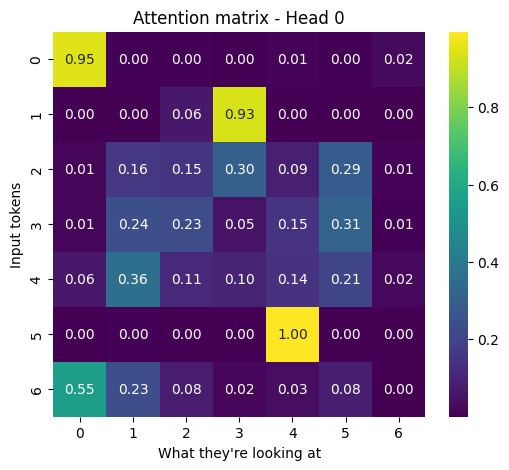

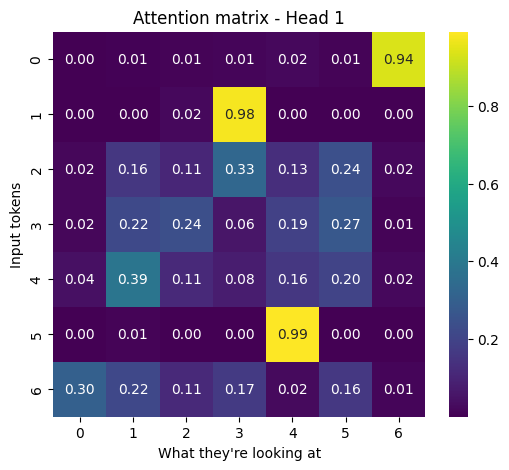

In [ ]:
def plot_attention(model, input_seq, headNumber):
    # Obtener los pesos de atención completos
    attn_weights = get_attention_weights(model, input_seq)
    head_weights = attn_weights[0, headNumber]  # Esto da un tensor [7, 7]

    plt.figure(figsize=(6, 5))
    sns.heatmap(head_weights.cpu().numpy(), cmap="viridis", annot=True, fmt=".2f")
    plt.title(f"Attention matrix - Head {headNumber}")
    plt.xlabel("What they're looking at")
    plt.ylabel("Input tokens")
    plt.show()

# Llamar para cada cabeza

print(f"input sequence = {input_tensor}")
plot_attention(model, input_tensor, 0)
plot_attention(model, input_tensor, 1)

I tend to believe is learning a sorting algorithm based on swapping (maybe bubble sort or maybe selection searching for the lowest and the biggest). I think this because the fifth token is looking a lot (almost all of his attention) to the 3 token which is the largest number and the first token is doing the same to the fourth which is the lowest number. I'm not considering the begin and end tokens.
Note: this may change when trained again, it's so no deterministic!

Let's do more examples

input sequence = tensor([[ 0, 10, 20, 30, 40, 50, 51]])


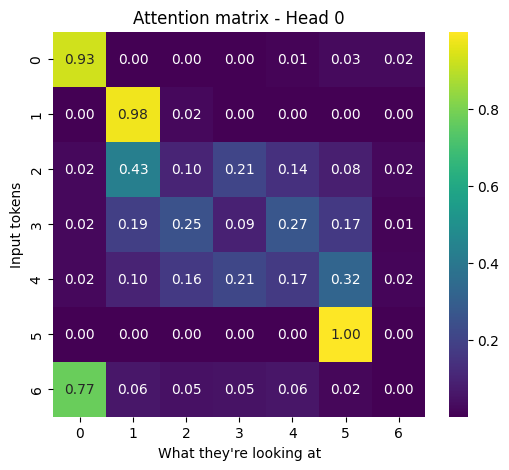

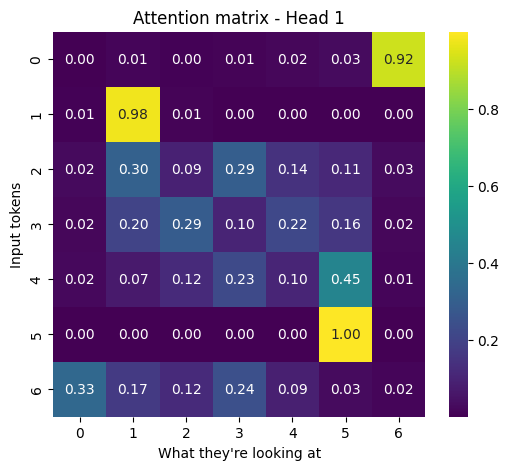

input sequence = tensor([[ 0, 50, 40, 30, 20, 10, 51]])


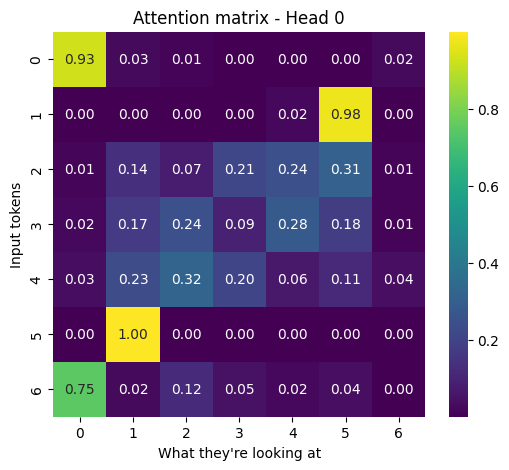

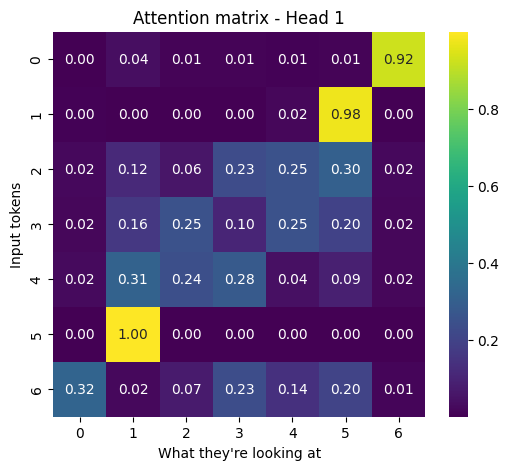

input sequence = tensor([[ 0, 10, 50, 20, 40, 30, 51]])


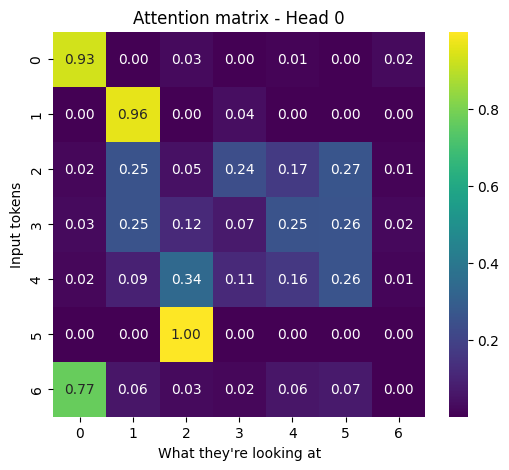

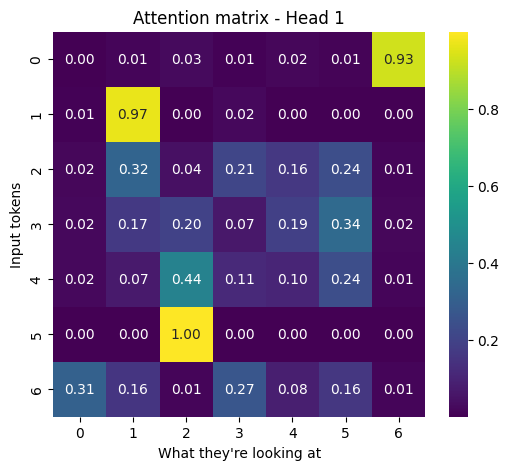

In [ ]:
test_cases = [
    [0, 10, 20, 30, 40, 50, 51],
    [0, 50, 40, 30, 20, 10, 51],
    [0, 10, 50, 20, 40, 30, 51],
]

for case in test_cases:
    input_tensor = torch.tensor(case).unsqueeze(0)
    print(f"input sequence = {input_tensor}")
    plot_attention(model, input_tensor, 0)
    plot_attention(model, input_tensor, 1)

So... It seems to be something like this: \\
-For the first and last positions always looks for the biggest and smallest number (very confident). \\
-For the others positions looks for numbers near itself and maybe tries to compare with them

Maybe I should take a deeper look into the sorting algorithm